# 📊 Phân Tích Hành Vi Khách Hàng - DataSquad Retail - Nguyễn Đức Anh

#### ✓ Import Các Thư Viện Cần Thiết

In [48]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import plotly.express as px
from dash import Dash, dcc, html

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, \
                            classification_report, confusion_matrix, ConfusionMatrixDisplay,roc_auc_score
from dash import Dash, dcc, html, Input, Output
from imblearn.over_sampling import SMOTE
import plotly.express as px


#### ✓ Đọc file CSV

In [3]:
file_path = "marketing_campaign.csv"

# Sử dụng ký tự phân tách là tab '\t'.
customer_data = pd.read_csv(file_path, sep='\t')


#### ✓ Kiểm Tra Dữ Liệu

### + Kiểm tra các dòng dữ liệu đầu tiên

In [4]:
customer_data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


### + Kiểm tra thông tin tổng quát

In [5]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

### + Kiểm tra giá trị thiếu

In [6]:
def Check_missing(x):
    check = x.isnull().sum()
    miss_values = check[check > 0]

    print('Very good') if check.sum() == 0 else print(f'Cột và giá trị thiếu của nó:\n{miss_values}')

Check_missing(customer_data)

Cột và giá trị thiếu của nó:
Income    24
dtype: int64


### + Kiểm tra giá trị ngoại lệ

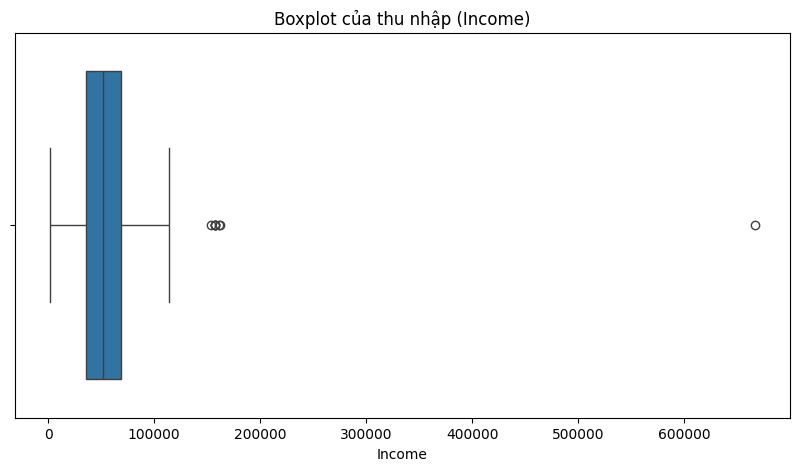

In [7]:
# Kiểm tra các giá trị ngoại lệ trong cột 'Income'
plt.figure(figsize=(10, 5))
sns.boxplot(x=customer_data['Income'].dropna())
plt.title('Boxplot của thu nhập (Income)')
plt.xlabel('Income')

plt.show()


### + Kiểm tra dữ liệu trùng lặp

In [8]:
trung_lap = customer_data.duplicated().sum()
print(f"Số dòng bị trùng lặp dữ liệu: {trung_lap}")

Số dòng bị trùng lặp dữ liệu: 0


### + Kiểm tra các cột có giá trị duy nhất

In [9]:
constant_columns = [x for x in customer_data.columns if customer_data[x].nunique() == 1]
print(f"Các cột có giá trị duy nhất: {constant_columns}")

Các cột có giá trị duy nhất: ['Z_CostContact', 'Z_Revenue']


## ✓ Làm Sạch Dữ Liệu

### + Xử lý giá trị thiếu (Missing values):

In [10]:
# Xử lý giá trị thiếu trong cột 'Income' bằng cách điền giá trị trung vị
def Fill_missing(column):
    return column.fillna(column.median().round(), inplace=True)

Fill_missing(customer_data.Income)

### + Xử lý giá trị ngoại lệ

In [11]:
# Xác định giá trị ngoại lệ bằng phương pháp IQR
def IQR_outliers(df, column):
    hang_so = 1.5

    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Xác định ngưỡng dưới và ngưỡng trên
    lower_bound = Q1 - hang_so * IQR
    upper_bound = Q3 + hang_so * IQR

    return df.query(f"{lower_bound} <= {column} <= {upper_bound}")
     

customer_data = IQR_outliers(customer_data, 'Income')

### + Loại bỏ giá trị trùng lặp:

In [12]:
customer_data.drop_duplicates(inplace=True)

### + Loại bỏ các cột không cần thiết (chứa các giá trị không đổi):

In [13]:
customer_data.drop(columns=constant_columns, inplace=True)

## ✓ Chuyển Đổi Dữ Liệu

### + Chuẩn Hóa

In [14]:
# Chuẩn hóa cấp độ học vấn
def Chuan_hoa_hoc_van(education):
    mapping = {
        'Graduation': 'Tốt nghiệp',
        'PhD': 'Tiến sĩ',
        'Master': 'Thạc sĩ',
        'Basic': 'Cơ bản',
        '2n Cycle': 'Chu kỳ 2'
    }
    
    return mapping.get(education, 'Khác')

customer_data['Education'] = customer_data['Education'].apply(Chuan_hoa_hoc_van)


In [15]:
# Chuẩn hóa tình trạng hôn nhân
def Chuan_hoa_tinh_trang(status):
    mapping = {
        'Single': 'Độc thân',
        'Together': 'Sống chung',
        'Married': 'Sống chung',
        'Divorced': 'Độc thân',
        'Widow': 'Độc thân',
        'Alone': 'Độc thân',
        'Absurd': 'Độc thân',
        'YOLO': 'Độc thân'
    }
    return mapping.get(status, 'Không xác định')

customer_data['Marital_Status'] = customer_data['Marital_Status'].apply(Chuan_hoa_tinh_trang)

### + Chuyển Đổi Kiểu Dữ Liệu

In [16]:
# Hàm chuyển đổi kiểu dữ liệu
def convert_type(df, lst_column, type):
    for i in lst_column:
        if i in df.columns:
            df[i] = df[i].astype(type)
            print(f"Cột '{i}' đã được chuyển đổi kiểu dữ liệu !!!")
        else:
            print(f"Cột '{i}' không tồn tại trong Dataframe !!!")

In [17]:
# Chuyển đổi cột 'Dt_Customer' sang định dạng ngày tháng (datetime)
customer_data['Dt_Customer'] = pd.to_datetime(customer_data['Dt_Customer'], format='%d-%m-%Y', errors='coerce')

# Kiểm tra các giá trị bị lỗi khi chuyển đổi ngày tháng
Check_missing(customer_data.Dt_Customer)


Very good


In [18]:
# Chuyển đổi cột 'ID' sang kiểu chuỗi
convert_type(customer_data, ['ID'], 'str')

Cột 'ID' đã được chuyển đổi kiểu dữ liệu !!!


In [19]:
# Chuyển đổi sang dạng 'category'
convert_type(customer_data, ['Education', 'Marital_Status'], 'category')

Cột 'Education' đã được chuyển đổi kiểu dữ liệu !!!
Cột 'Marital_Status' đã được chuyển đổi kiểu dữ liệu !!!


In [20]:
# Chuyển đổi sang kiểu 'boolean'
boolean_columns = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response']

convert_type(customer_data, boolean_columns, 'bool')


Cột 'AcceptedCmp3' đã được chuyển đổi kiểu dữ liệu !!!
Cột 'AcceptedCmp4' đã được chuyển đổi kiểu dữ liệu !!!
Cột 'AcceptedCmp5' đã được chuyển đổi kiểu dữ liệu !!!
Cột 'AcceptedCmp1' đã được chuyển đổi kiểu dữ liệu !!!
Cột 'AcceptedCmp2' đã được chuyển đổi kiểu dữ liệu !!!
Cột 'Complain' đã được chuyển đổi kiểu dữ liệu !!!
Cột 'Response' đã được chuyển đổi kiểu dữ liệu !!!


### + Việt hóa tên các cột

In [21]:
new_header = {
    'ID': 'Mã_KH',
    'Education': 'Trình_Độ_Học_Vấn',
    'Marital_Status': 'Tình_Trạng_Hôn_Nhân',
    'Income': 'Thu_Nhập',
    'Recency': 'Khoảng_Cách_Lần_Mua_Cuối',
    'MntWines': 'Chi_Tiêu_Rượu',
    'MntFruits': 'Chi_Tiêu_Trái_Cây',
    'MntMeatProducts': 'Chi_Tiêu_Thịt',
    'MntFishProducts': 'Chi_Tiêu_Cá',
    'MntSweetProducts': 'Chi_Tiêu_Bánh_Kẹo',
    'MntGoldProds': 'Chi_Tiêu_Vàng_Bạc',
    'NumDealsPurchases': 'Số_Lần_Mua_Khuyến_Mãi',
    'NumWebPurchases': 'Số_Lần_Mua_Qua_Web',
    'NumCatalogPurchases': 'Số_Lần_Mua_Qua_Catalog',
    'NumStorePurchases': 'Số_Lần_Mua_Tại_Cửa_Hàng',
    'NumWebVisitsMonth': 'Số_Lần_Truy_Cập_Web',
    'AcceptedCmp3': 'Chấp_Nhận_Chiến_Dịch_3',
    'AcceptedCmp4': 'Chấp_Nhận_Chiến_Dịch_4',
    'AcceptedCmp5': 'Chấp_Nhận_Chiến_Dịch_5',
    'AcceptedCmp1': 'Chấp_Nhận_Chiến_Dịch_1',
    'AcceptedCmp2': 'Chấp_Nhận_Chiến_Dịch_2',
    'Complain': 'Khiếu_Nại',
    'Response': 'Phản_Hồi'
}

customer_data.rename(columns=new_header, inplace=True)


## ✓ Tạo Các Cột Mới (Phân Tích Sâu)

### + Tạo cột 'Tổng_Số_Con'

In [22]:
customer_data['Tổng_Số_Con'] = customer_data['Kidhome'] + customer_data['Teenhome']

### + Tạo cột 'Tuổi_KH'

In [23]:
def Age(column):
    return pd.to_datetime('today').year - column

customer_data['Tuổi_KH'] = customer_data['Year_Birth'].apply(Age)

### + Tạo cột 'Tổng_Chi_Tiêu'

In [24]:
customer_data['Tổng_Chi_Tiêu'] = (
    customer_data.Chi_Tiêu_Rượu +
    customer_data.Chi_Tiêu_Trái_Cây +
    customer_data.Chi_Tiêu_Thịt +
    customer_data.Chi_Tiêu_Cá +
    customer_data.Chi_Tiêu_Bánh_Kẹo +
    customer_data.Chi_Tiêu_Vàng_Bạc
)

### + Tạo cột 'Thâm_Niên_KH' (tháng) để tính số năm khách hàng đã tham gia

In [25]:
# Thâm niên của khách hàng (tháng kể từ ngày đăng ký)
def Tenure(column):
    result = (pd.to_datetime('today') - column).days / 30.44
    return round(result)

customer_data['Thâm_Niên_KH'] = customer_data['Dt_Customer'].apply(Tenure)

### + Tạo cột 'Nhóm_Tuổi'

In [26]:
def Age_group(column):
    labels_Age = ['Thanh niên', 'Trưởng thành', 'Cao tuổi']
    bins = [0, 35, 60, float('inf')]
    return pd.cut(column, bins=bins, labels=labels_Age)

customer_data['Nhóm_Tuổi'] = Age_group(customer_data['Tuổi_KH'])

### + Tạo cột 'Nhóm_Thu_Nhập'

In [27]:
def Income_group(col):
    labels_Income = [
        'Thu nhập thấp', 'Thu nhập trung bình thấp',
        'Thu nhập trung bình cao', 'Thu nhập cao'
    ]

    return pd.qcut(col, q=4, labels=labels_Income)

customer_data['Nhóm_Thu_Nhập'] = Income_group(customer_data['Thu_Nhập'])


## ✓ Kiểm Tra Dữ Liệu Sau Xử Lý

### + Lựa chọn các cột cần thiết để sử dụng.

In [28]:
final_customer_data = customer_data[
    ['Mã_KH', 'Tuổi_KH', 'Trình_Độ_Học_Vấn', 'Tình_Trạng_Hôn_Nhân', 'Tổng_Số_Con', 'Thu_Nhập',
     'Thâm_Niên_KH', 'Tổng_Chi_Tiêu', 'Chi_Tiêu_Rượu', 'Chi_Tiêu_Trái_Cây', 'Chi_Tiêu_Thịt',
     'Chi_Tiêu_Cá', 'Chi_Tiêu_Bánh_Kẹo', 'Chi_Tiêu_Vàng_Bạc', 'Số_Lần_Mua_Khuyến_Mãi',
     'Số_Lần_Mua_Qua_Web', 'Số_Lần_Mua_Qua_Catalog', 'Số_Lần_Mua_Tại_Cửa_Hàng',
     'Số_Lần_Truy_Cập_Web', 'Chấp_Nhận_Chiến_Dịch_1', 'Chấp_Nhận_Chiến_Dịch_2',
     'Chấp_Nhận_Chiến_Dịch_3', 'Chấp_Nhận_Chiến_Dịch_4', 'Chấp_Nhận_Chiến_Dịch_5',
     'Khiếu_Nại', 'Phản_Hồi']
]


### + Xem lại các dòng dữ liệu đầu

In [29]:
final_customer_data.head()

,Mã_KH,Tuổi_KH,Trình_Độ_Học_Vấn,Tình_Trạng_Hôn_Nhân,Tổng_Số_Con,Thu_Nhập,Thâm_Niên_KH,Tổng_Chi_Tiêu,Chi_Tiêu_Rượu,Chi_Tiêu_Trái_Cây,...,Số_Lần_Mua_Qua_Catalog,Số_Lần_Mua_Tại_Cửa_Hàng,Số_Lần_Truy_Cập_Web,Chấp_Nhận_Chiến_Dịch_1,Chấp_Nhận_Chiến_Dịch_2,Chấp_Nhận_Chiến_Dịch_3,Chấp_Nhận_Chiến_Dịch_4,Chấp_Nhận_Chiến_Dịch_5,Khiếu_Nại,Phản_Hồi
0,5524,68,Tốt nghiệp,Độc thân,0,58138.0,150,1617,635,88,...,10,4,7,False,False,False,False,False,False,True
1,2174,71,Tốt nghiệp,Độc thân,2,46344.0,132,27,11,1,...,1,2,5,False,False,False,False,False,False,False
2,4141,60,Tốt nghiệp,Sống chung,0,71613.0,138,776,426,49,...,2,10,4,False,False,False,False,False,False,False
3,6182,41,Tốt nghiệp,Sống chung,1,26646.0,133,53,11,4,...,0,4,6,False,False,False,False,False,False,False
4,5324,44,Tiến sĩ,Sống chung,1,58293.0,133,422,173,43,...,3,6,5,False,False,False,False,False,False,False


### + Kiểm tra kích thước

In [30]:
rows, columns = final_customer_data.shape
print(f"Số dòng: {rows}, số cột: {columns}")

Số dòng: 2232, số cột: 26


### + Thống kê mô tả

In [31]:
final_customer_data.describe()

,Tuổi_KH,Tổng_Số_Con,Thu_Nhập,Thâm_Niên_KH,Tổng_Chi_Tiêu,Chi_Tiêu_Rượu,Chi_Tiêu_Trái_Cây,Chi_Tiêu_Thịt,Chi_Tiêu_Cá,Chi_Tiêu_Bánh_Kẹo,Chi_Tiêu_Vàng_Bạc,Số_Lần_Mua_Khuyến_Mãi,Số_Lần_Mua_Qua_Web,Số_Lần_Mua_Qua_Catalog,Số_Lần_Mua_Tại_Cửa_Hàng,Số_Lần_Truy_Cập_Web
count,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000
mean,56.207437,0.951613,51630.932348,139.731631,605.596326,304.930108,26.380376,165.319444,37.644713,27.155466,44.166219,2.318100,4.097670,2.636201,5.808244,5.331541
std,11.990340,0.751742,20601.679477,6.661242,601.444172,336.784950,39.821532,219.401447,54.689504,41.325414,52.204505,1.894595,2.774726,2.795959,3.242198,2.415275
min,29.000000,0.000000,1730.000000,128.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,35434.750000,134.000000,69.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000
50%,55.000000,1.000000,51382.000000,140.000000,396.500000,176.000000,8.000000,67.000000,12.000000,8.000000,24.500000,2.000000,4.000000,2.000000,5.000000,6.000000
75%,66.000000,1.000000,68118.000000,145.000000,1044.250000,505.000000,33.000000,231.250000,50.000000,34.000000,56.250000,3.000000,6.000000,4.000000,8.000000,7.000000
max,132.000000,3.000000,113734.000000,151.000000,2525.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000


## ✓ Xuất Dữ Liệu

In [32]:
# Lưu trữ dữ liệu đã xử lý
final_customer_data.to_csv('Customer_data.csv', index=False, encoding='utf-8-sig')


## ✓ Trực Quan, Dự Đoán và Phân Tích.

In [33]:
clean_data = customer_data.drop(columns=['Year_Birth', 'Kidhome', 'Teenhome', 'Dt_Customer'])

### + Trực Quan Hóa

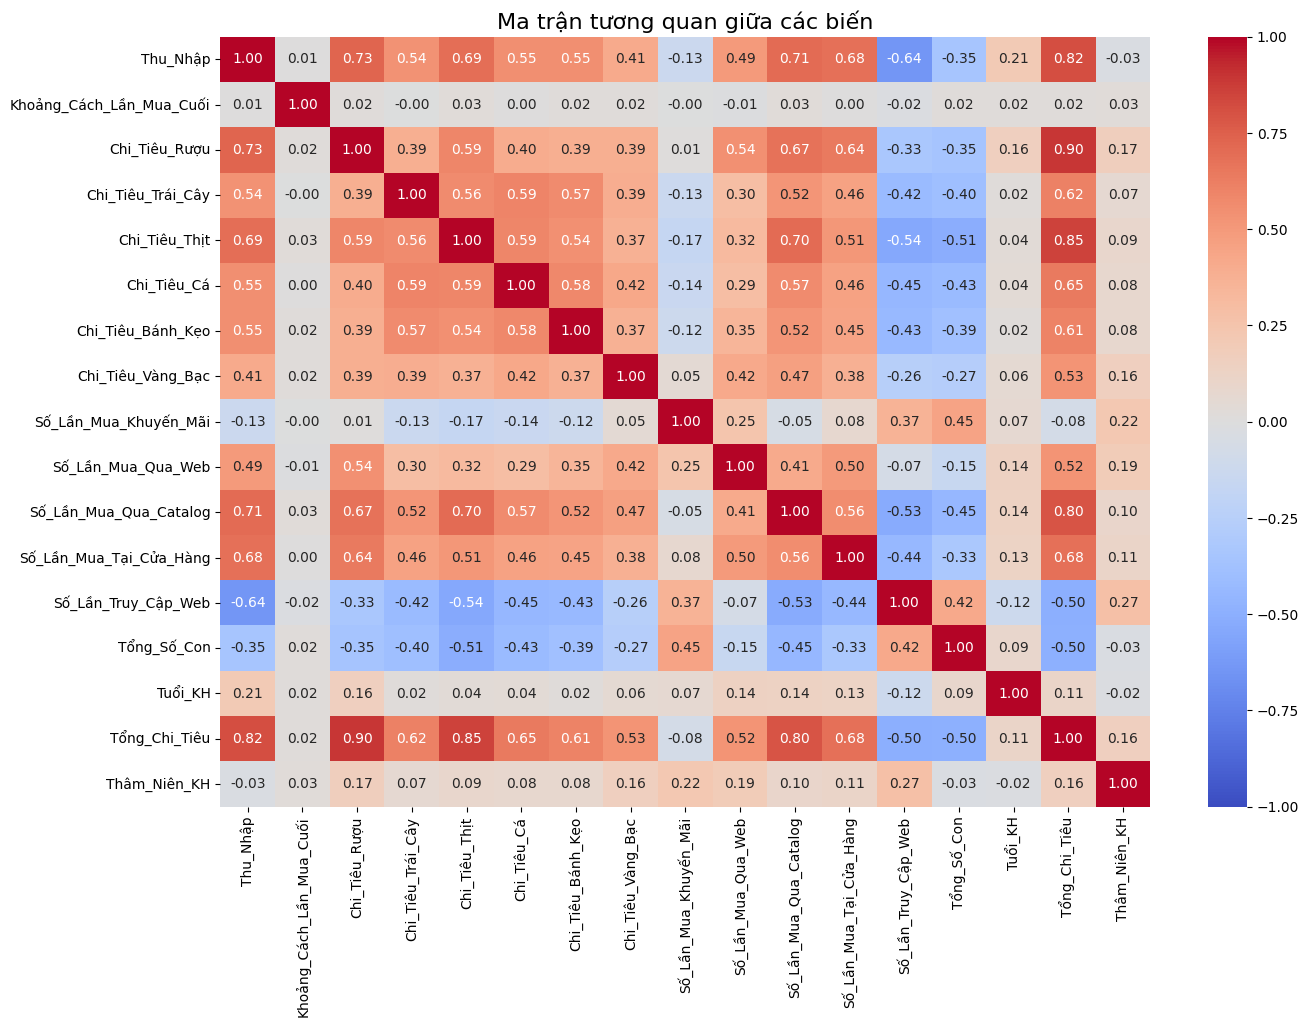

In [34]:
numerical_data = clean_data.select_dtypes(include=[np.number])

# Tính toán ma trận tương quan
correlation_matrix = numerical_data.corr()

# Trực quan hóa ma trận tương quan
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Ma trận tương quan giữa các biến", fontsize=16)
plt.show()

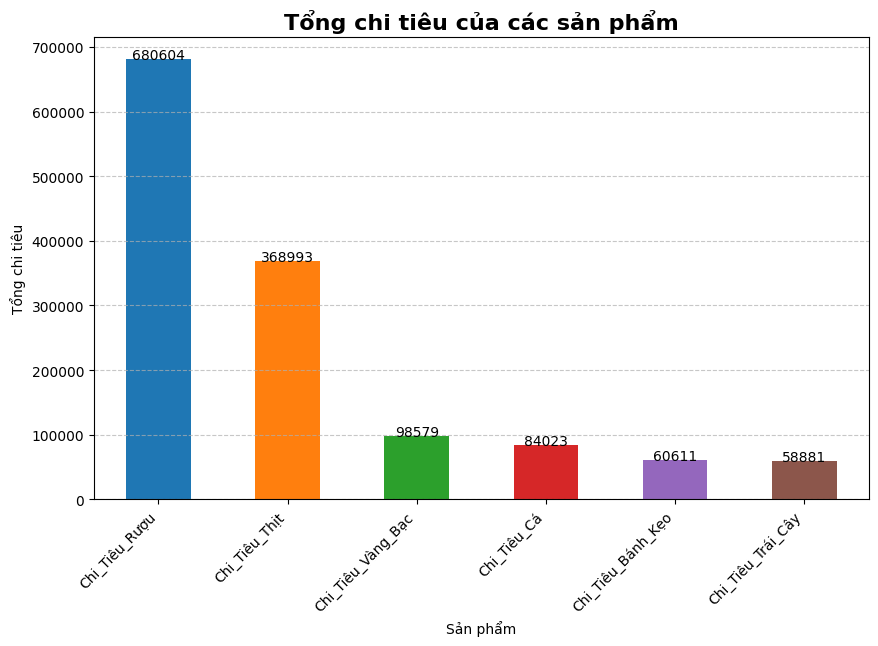

In [35]:
chi_tieu_sp = clean_data[
    ['Chi_Tiêu_Rượu', 'Chi_Tiêu_Trái_Cây', 'Chi_Tiêu_Thịt',
                             'Chi_Tiêu_Cá', 'Chi_Tiêu_Bánh_Kẹo', 'Chi_Tiêu_Vàng_Bạc']].sum()
chi_tieu_sp.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
colors = plt.cm.tab10(range(len(chi_tieu_sp)))
ax = chi_tieu_sp.plot.bar(color = colors, legend=False)

plt.title("Tổng chi tiêu của các sản phẩm", fontsize=16, fontweight='bold')
plt.xlabel("Sản phẩm")
plt.ylabel("Tổng chi tiêu")

for i, value in enumerate(chi_tieu_sp.values):
    plt.text(i, value + 0.1, str(value), ha='center')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha="right")
plt.show()


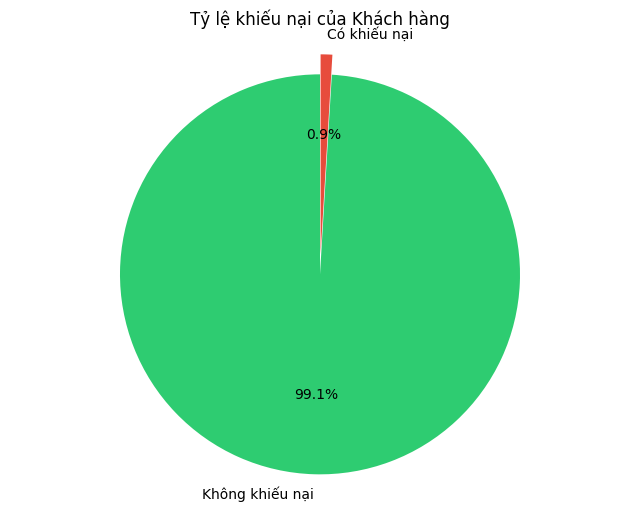

In [36]:
# Tính toán số lượng cho từng giá trị trong cột 'Khiếu_Nại'
complaint_counts = clean_data['Khiếu_Nại'].value_counts()

# Định nghĩa nhãn và màu sắc cho biểu đồ 'Khiếu_Nại'
labels_complaint = ['Không khiếu nại', 'Có khiếu nại']
colors_complaint = ['#2ecc71', '#e74c3c']

# Tạo biểu đồ hình tròn cho cột 'Khiếu_Nại'
plt.figure(figsize=(8, 6))
plt.pie(complaint_counts, labels=labels_complaint, colors=colors_complaint, autopct='%1.1f%%', startangle=90, explode=(0, 0.1))
plt.title('Tỷ lệ khiếu nại của Khách hàng')
plt.axis('equal')
plt.show()

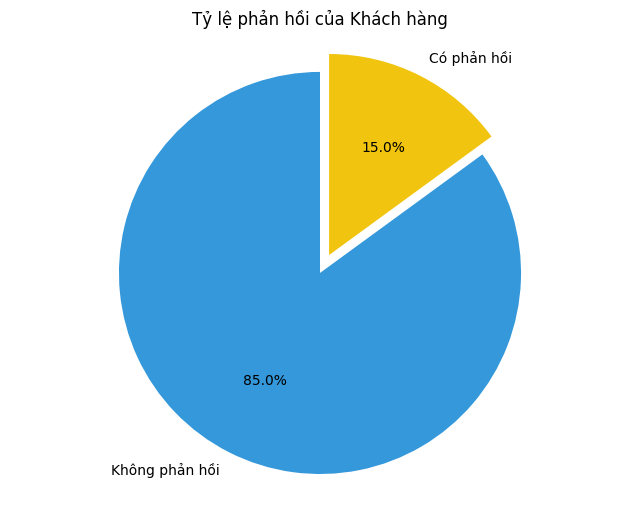

In [37]:
# Tính toán số lượng cho từng giá trị trong cột 'Phản_Hồi'
response_counts = clean_data['Phản_Hồi'].value_counts()

# Định nghĩa nhãn và màu sắc cho biểu đồ 'Phản_Hồi'
labels_response = ['Không phản hồi', 'Có phản hồi']
colors_response = ['#3498db', '#f1c40f']

# Tạo biểu đồ hình tròn cho cột 'Phản_Hồi'
plt.figure(figsize=(8, 6))
plt.pie(response_counts, labels=labels_response, colors=colors_response, autopct='%1.1f%%', startangle=90, explode=(0, 0.1))
plt.title('Tỷ lệ phản hồi của Khách hàng')
plt.axis('equal')
plt.show()

### + Dashboard

In [38]:
marketing_campaigns = ['Chấp_Nhận_Chiến_Dịch_1', 'Chấp_Nhận_Chiến_Dịch_2',
        'Chấp_Nhận_Chiến_Dịch_3', 'Chấp_Nhận_Chiến_Dịch_4', 'Chấp_Nhận_Chiến_Dịch_5']

campaign_acceptance_counts = clean_data[marketing_campaigns].sum()

highest_campaign = campaign_acceptance_counts.idxmax()

income_vs_campaign = clean_data.groupby('Nhóm_Thu_Nhập')[marketing_campaigns].sum()

app = Dash(__name__)

app.layout = html.Div([
    html.H1("Dashboard: Hiệu quả các chiến dịch Marketing", style={'text-align': 'center'}),

    # Bố cục 2 cột, 2 hàng
    html.Div([
        # Viz 1: Số lượng chấp nhận của các chiến dịch
        html.Div([
            dcc.Graph(
                id='viz1',
                figure=px.bar(
                    campaign_acceptance_counts,
                    x=campaign_acceptance_counts.index,
                    y=campaign_acceptance_counts.values,
                    title="Số lượng chấp nhận của các Chiến dịch",
                    labels={"x": "Chiến dịch", "y": "Số lượng chấp nhận"},
                    color=campaign_acceptance_counts.index,
                    color_discrete_sequence=px.colors.qualitative.Pastel
                )
            )
        ], style={'width': '48%', 'display': 'inline-block', 'padding': '10px'}),

        # Viz 2: So sánh toàn bộ chiến dịch (làm nổi bật chiến dịch cao nhất)
        html.Div([
            dcc.Graph(
                id='viz2',
                figure=px.bar(
                    income_vs_campaign,
                    barmode="group",
                    title="So sánh tất cả các chiến dịch với Nhóm Thu nhập",
                    labels={"index": "Chiến dịch", "value": "Số lượng"}
                ).update_traces(
                    marker_color=['#FF5733' if col == highest_campaign else '#3498DB' for col in income_vs_campaign.index]
                )
            )
        ], style={'width': '48%', 'display': 'inline-block', 'padding': '10px'}),
    ]),

    html.Div([
        # Viz 3: Heatmap mối quan hệ giữa Phản Hồi và Khiếu Nại (di chuyển lên trên)
        html.Div([
            dcc.Graph(
                id='viz3',
                figure=px.imshow(
                    pd.crosstab(clean_data['Khiếu_Nại'], clean_data['Phản_Hồi']),
                    text_auto=True,
                    color_continuous_scale='Blues',
                    title="Mối quan hệ giữa Phản Hồi và Khiếu Nại",
                    labels=dict(x="Phản Hồi", y="Khiếu Nại", color="Số lượng")
                )
            )
        ], style={'width': '48%', 'display': 'inline-block', 'padding': '10px'}),

        # Viz 4: Boxplot cho Tổng Chi Tiêu so với Nhóm Thu Nhập và Khiếu Nại
        html.Div([
            dcc.Graph(
                id='viz4-boxplot',
                figure=px.box(
                    clean_data,
                    x='Nhóm_Thu_Nhập',  
                    y='Tổng_Chi_Tiêu', 
                    color='Khiếu_Nại', 
                    title="So sánh Tổng Chi Tiêu giữa Nhóm Thu Nhập và Khiếu Nại",
                    labels={"Nhóm_Thu_Nhập": "Nhóm Thu Nhập", "Tổng_Chi_Tiêu": "Tổng Chi Tiêu", "Khiếu_Nại": "Khiếu Nại"},
                    category_orders={"Khiếu_Nại": ["True", "False"]}, 
                    height=600
                )
            )
        ], style={'width': '48%', 'display': 'inline-block', 'padding': '10px'}),
    ])
])

if __name__ == '__main__':
    app.run_server(debug=True, port=8051)


C:\Users\Admin\AppData\Local\Temp\ipykernel_8704\3126472048.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_vs_campaign = clean_data.groupby('Nhóm_Thu_Nhập')[marketing_campaigns].sum()


#### 📌 Mô hình dự báo tổng chi tiêu

In [50]:
X = numerical_data.drop(columns=['Tổng_Chi_Tiêu'])
y = numerical_data['Tổng_Chi_Tiêu']

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Khởi tạo mô hình hồi quy tuyến tính và huấn luyện
model = LinearRegression()
model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred_linear = model.predict(X_test)

# Đánh giá hiệu suất của mô hình
mae = mean_absolute_error(y_test, y_pred_linear)
mse = mean_squared_error(y_test, y_pred_linear)
r2 = r2_score(y_test, y_pred_linear)

print("Sai số tuyệt đối trung bình (MAE):", mae)
print("Sai số bình phương trung bình (MSE):", mse)
print("Hệ số xác định (R^2):", r2)


Sai số tuyệt đối trung bình (MAE): 4.76995557480236e-13
Sai số bình phương trung bình (MSE): 3.979467388705031e-25
Hệ số xác định (R^2): 1.0


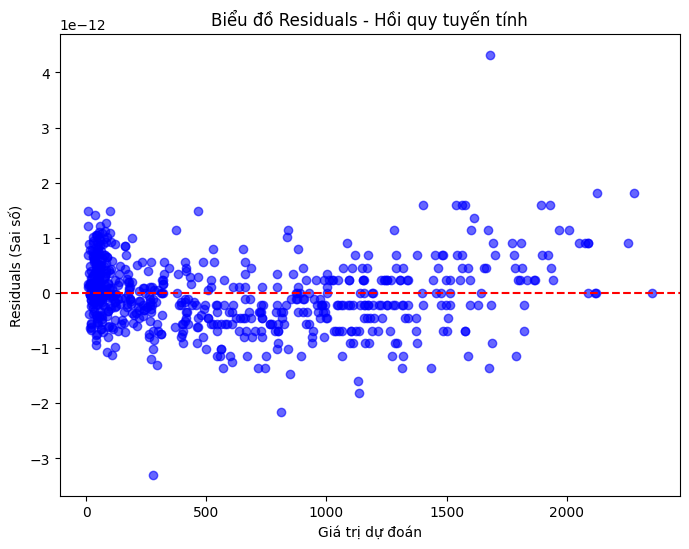

In [51]:

# Tính toán residuals
residuals = y_test - y_pred_linear

plt.figure(figsize=(8, 6))
plt.scatter(y_pred_linear, residuals, color='blue', alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Giá trị dự đoán')
plt.ylabel('Residuals (Sai số)')
plt.title('Biểu đồ Residuals - Hồi quy tuyến tính')
plt.show()



#### 📌 Mô hình dự báo phản hồi marketing

In [53]:
# 📌 Mô hình dự báo phản hồi marketing
X = clean_data[["Tuổi_KH", "Thu_Nhập", "Tổng_Chi_Tiêu"]]
y = clean_data["Phản_Hồi"]

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Xây dựng mô hình hồi quy logistic
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred_logistic = logistic_model.predict(X_test)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred_logistic)

print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred_logistic))



Accuracy: 0.8366890380313199
              precision    recall  f1-score   support

       False       0.85      0.99      0.91       378
        True       0.17      0.01      0.03        69

    accuracy                           0.84       447
   macro avg       0.51      0.50      0.47       447
weighted avg       0.74      0.84      0.77       447



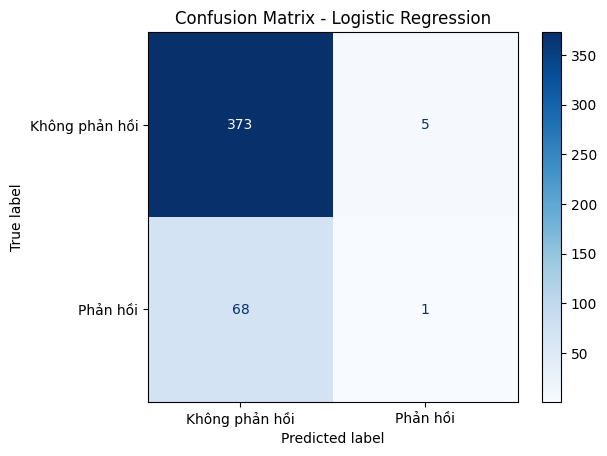

In [54]:
# Tính toán confusion matrix
cm_logistic = confusion_matrix(y_test, y_pred_logistic)

disp_logistic = ConfusionMatrixDisplay(confusion_matrix=cm_logistic, display_labels=["Không phản hồi", "Phản hồi"])
disp_logistic.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix - Logistic Regression")
plt.show()
